## Getting Started

In [1]:
import requests
import json
import pandas as pd

In [2]:
api_key="YOUR-API-KEY"

## Analysis Areas

In [3]:
df = pd.read_csv("data/mcdonalds_san_francisco.csv")
df.shape[0]

11

In [4]:
df.head()

,Business Name,Address,City,State,ZIP
0,McDonald's,145 Jefferson St,San Francisco,CA,94133
1,McDonald's,345 Bay Shore Blvd,San Francisco,CA,94124
2,McDonald's,1100 Fillmore St,San Francisco,CA,94115
3,McDonald's,5411 3rd St,San Francisco,CA,94124
4,McDonald's,2801 Mission St,San Francisco,CA,94110


## Basics

In [5]:
ge_url = 'https://geoenrich.arcgis.com/arcgis/rest/services/World/geoenrichmentserver/Geoenrichment/Enrich'

In [6]:
mac_study_areas = [{"address":x, "attributes":{"address":x["Address"]}} for x in df.to_dict('records')]
mac_study_areas[:2]

[{'address': {'Business Name': "McDonald's",
   'Address': '145 Jefferson St',
   'City': 'San Francisco',
   'State': 'CA',
   'ZIP': 94133},
  'attributes': {'address': '145 Jefferson St'}},
 {'address': {'Business Name': "McDonald's",
   'Address': '345 Bay Shore Blvd',
   'City': 'San Francisco',
   'State': 'CA',
   'ZIP': 94124},
  'attributes': {'address': '345 Bay Shore Blvd'}}]

In [7]:
enrichment_params = {
    'studyareas':str(mac_study_areas),
    'analysisvariables':str(["Wealth.AVGIA15_CY","Wealth.AVGIA25_CY"]),
    'returngeometry':'true', # to display areas
    'f':'json',
    'token':api_key
}

In [8]:
response = requests.post(ge_url, data=enrichment_params)

In [9]:
fs_json = json.loads(response.text)["results"][0]["value"]["FeatureSet"][0]

enriched_df = pd.DataFrame(f["attributes"] for f in fs_json["features"])
enriched_df.head()

,ID,OBJECTID,sourceCountry,address,X,Y,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,AVGIA15_CY,AVGIA25_CY
0,0,1,US,145 Jefferson St,-122.414643,37.808061,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,112682,171262
1,1,2,US,345 Bay Shore Blvd,-122.405194,37.742088,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,104163,155220
2,2,3,US,1100 Fillmore St,-122.431662,37.779881,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,94806,152561
3,3,4,US,5411 3rd St,-122.392711,37.728051,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,61191,107889
4,4,5,US,2801 Mission St,-122.418426,37.752209,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,126032,178289


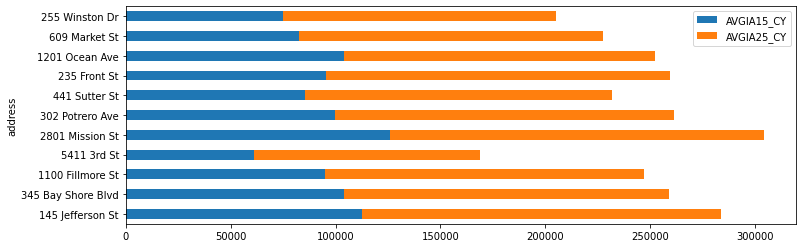

In [10]:
plot = enriched_df[["address","AVGIA15_CY","AVGIA25_CY",]].plot.barh(x='address', stacked=True, figsize=(12, 4))


## Map Results

In [11]:
from arcgis.gis import GIS
from arcgis.features import FeatureSet

gis = GIS(apiKey=api_key)

In [12]:
sf_map = gis.map('San Francisco', zoomlevel=12)
sf_map.basemap = 'openstreetmap'
sf_map

MapView(layout=Layout(height='400px', width='100%'))

In [13]:
enriched_df = FeatureSet.from_dict(fs_json).sdf
enriched_df.head(n=2)

,ID,OBJECTID,sourceCountry,address,X,Y,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,AVGIA15_CY,AVGIA25_CY,SHAPE
0,0,1,US,145 Jefferson St,-122.414643,37.808061,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,112682,171262,"{""rings"": [[[-122.4146430205622, 37.8225605528..."
1,1,2,US,345 Bay Shore Blvd,-122.405194,37.742088,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,104163,155220,"{""rings"": [[[-122.40519401729348, 37.756587719..."


In [14]:
enriched_df["INCOME15_34"] = enriched_df["AVGIA15_CY"] + enriched_df["AVGIA25_CY"]
enriched_df.head(n=2)

,ID,OBJECTID,sourceCountry,address,X,Y,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,AVGIA15_CY,AVGIA25_CY,SHAPE,INCOME15_34
0,0,1,US,145 Jefferson St,-122.414643,37.808061,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,112682,171262,"{""rings"": [[[-122.4146430205622, 37.8225605528...",283944
1,1,2,US,345 Bay Shore Blvd,-122.405194,37.742088,RingBuffer,esriMiles,Miles,1,BlockApportionment:US.BlockGroups,2.191,2.576,1,104163,155220,"{""rings"": [[[-122.40519401729348, 37.756587719...",259383


In [15]:
fs = FeatureSet.from_dataframe(enriched_df)


sf_map.draw(fs)
sf_map.add_layer(fs, {'renderer':'ClassedSizeRenderer','field_name':'INCOME15_34'})

## Walking distance

In [16]:
enrichment_params = {
    'studyareas':str(mac_study_areas),
    'studyareasoptions':str({"areaType": "NetworkServiceArea", "travel_mode": "Walking", "bufferRadii": [15], "bufferUnits": "Minutes"}),
    'analysisvariables':str(["Wealth.AVGIA25_CY","Wealth.AVGIA15_CY"]),
    'f':'json',
    'returngeometry':'true',
    'token':api_key
}

In [17]:
response = requests.post(ge_url, data=enrichment_params)

In [18]:
fs_json = json.loads(response.text)["results"][0]["value"]["FeatureSet"][0]

enriched_df = FeatureSet.from_dict(fs_json).sdf
enriched_df.head(n=2)

,ID,OBJECTID,sourceCountry,address,X,Y,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,AVGIA15_CY,AVGIA25_CY,SHAPE
0,0,1,US,145 Jefferson St,-122.414643,37.808061,NetworkServiceArea,Minutes,Walk Time Minutes,15,BlockApportionment:US.BlockGroups,2.191,2.576,1,99991,158752,"{""rings"": [[[-122.41218985995754, 37.817749084..."
1,1,2,US,345 Bay Shore Blvd,-122.405194,37.742088,NetworkServiceArea,Minutes,Walk Time Minutes,15,BlockApportionment:US.BlockGroups,2.191,2.576,1,94653,169352,"{""rings"": [[[-122.402308436748, 37.75284610091..."


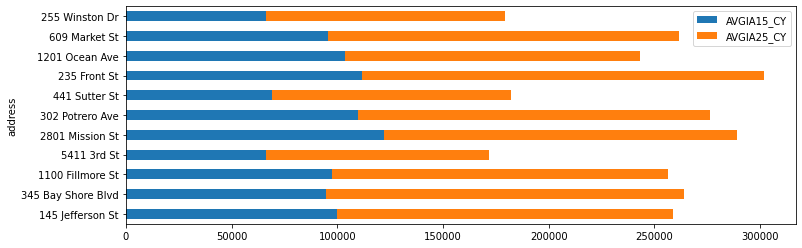

In [19]:
plot = enriched_df[["address","AVGIA15_CY","AVGIA25_CY",]].plot.barh(x='address', stacked=True, figsize=(12, 4))

In [20]:
sf_map2 = gis.map('San Francisco', zoomlevel=12)
sf_map2.basemap = 'openstreetmap'
sf_map2

MapView(layout=Layout(height='400px', width='100%'))

In [21]:
enriched_df["INCOME15_34"] = enriched_df["AVGIA15_CY"] + enriched_df["AVGIA25_CY"]
enriched_df.head(n=2)

,ID,OBJECTID,sourceCountry,address,X,Y,areaType,bufferUnits,bufferUnitsAlias,bufferRadii,aggregationMethod,populationToPolygonSizeRating,apportionmentConfidence,HasData,AVGIA15_CY,AVGIA25_CY,SHAPE,INCOME15_34
0,0,1,US,145 Jefferson St,-122.414643,37.808061,NetworkServiceArea,Minutes,Walk Time Minutes,15,BlockApportionment:US.BlockGroups,2.191,2.576,1,99991,158752,"{""rings"": [[[-122.41218985995754, 37.817749084...",258743
1,1,2,US,345 Bay Shore Blvd,-122.405194,37.742088,NetworkServiceArea,Minutes,Walk Time Minutes,15,BlockApportionment:US.BlockGroups,2.191,2.576,1,94653,169352,"{""rings"": [[[-122.402308436748, 37.75284610091...",264005


In [22]:
fs = FeatureSet.from_dataframe(enriched_df)


sf_map2.draw(fs)
sf_map2.add_layer(fs, {'renderer':'ClassedSizeRenderer','field_name':'INCOME15_34'})

## Creating Report

In [23]:
ge_report_url = 'https://geoenrich.arcgis.com/arcgis/rest/services/World/geoenrichmentserver/Geoenrichment/CreateReport'

In [24]:
report_params = {
    'studyareas':str(mac_study_areas[:1]),
    'studyareasoptions':str({"areaType": "NetworkServiceArea", "bufferUnits": "Minutes", "bufferRadii": [15], "travel_mode": "Walking"}),
    'report': "Demographic and Income Profile",
    'f':'bin',
    'token':api_key
}

In [25]:
response = requests.post(ge_report_url, data=report_params)

f = open("output/Demographic and Income Profile.pdf", 'wb')
f.write(response.content)
f.close()